# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from io import StringIO
import requests

import math
from tsad.evaluating.evaluating import evaluating #F1

import numpy as np
from itertools import chain # list of list to one bit list
from collections import namedtuple 

from scipy.signal import butter, filtfilt
from optcutfreq import optcutfreq
from detecta import detect_cusum #CUMSUM
from scipy.signal import savgol_filter

import sys
sys.path.append(r'/home/gishb/PycharmProjects/Fedot.Industrial') #SST
from core.operation.transformation.WindowSelection import WindowSizeSelection
from core.models.detection.subspaces.SSTdetector import SingularSpectrumTransformation

from scipy.signal import butter, filtfilt
from optcutfreq import optcutfreq

from scipy.signal import savgol_filter

# Dataset

In [2]:
def df_expirement():
    url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
    df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    return df

In [3]:
df = df_expirement()
df = df[df[df.columns[0]] == 'xxxAA684G']

df.replace(['-9999', -9999,'missing','#'], np.nan, inplace=True)
df = df[df['unitless'].notna()]
df = df.drop(axis=1, labels=(df.columns[0])) \
    .drop(axis=1, labels=(df.columns[1]))[['uR/h', 'unitless']].reset_index(drop=True)

In [4]:
#Create new columns for CPd and time
df['change_points'] = [1 if df['unitless'][i] !=  df['unitless'][i+1] else 0 for i in range(len(df)-1)] + [0]
df['time'] = np.arange(0, len(df)*1, 1).astype('datetime64[s]')
df = df.set_index('time')

In [5]:
df.head()

,uR/h,unitless,change_points
time,,,
1970-01-01 00:00:00,88.625,2.0,0
1970-01-01 00:00:01,107.250,2.0,0
1970-01-01 00:00:02,108.420,2.0,0
1970-01-01 00:00:03,109.590,2.0,0
1970-01-01 00:00:04,110.990,2.0,0


# Breef look at data

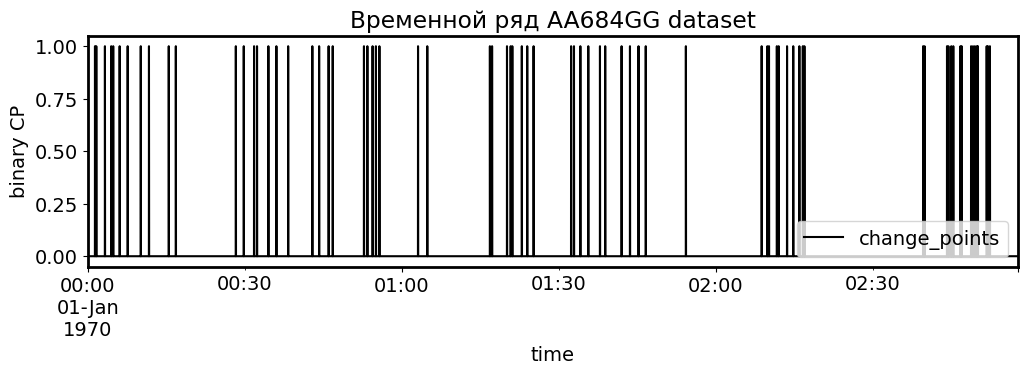

 Number CP: 74
 len data: 10664


In [6]:
df.change_points.plot(figsize=(12,3), color='black')
plt.legend(loc="lower right",)
plt.title('Временной ряд AA684GG dataset')
plt.ylabel('binary CP')
plt.show()
print(f' Number CP: {df[df["change_points"] == 1].count()[0]}')
print(f' len data: {df.count()[0]}')

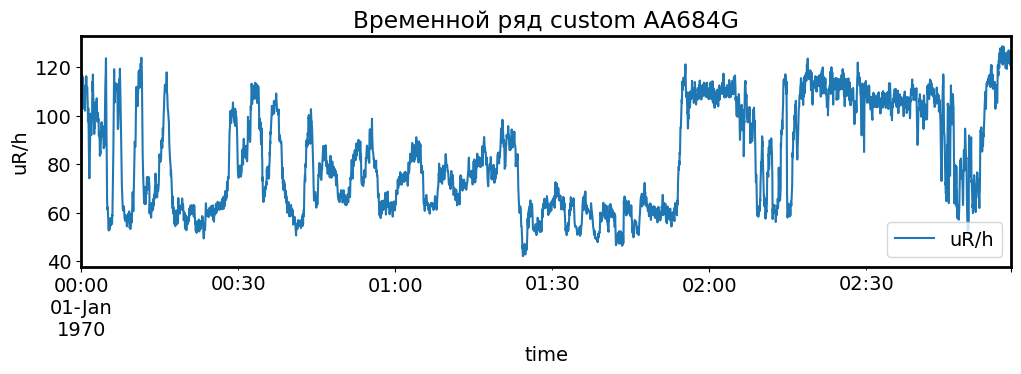

In [7]:
df['uR/h'].plot(figsize=(12,3))
plt.legend(loc="lower right")
plt.title('Временной ряд custom AA684G')
plt.ylabel('uR/h')
plt.show()

# Define filters & cumsumm & TSAD metric

In [8]:
def filter_butterworth(ts, freq): #list, int(1)
    '''
        Just butterworh filter
    '''
    fc_opt = optcutfreq(ts, freq=freq, show=False)

    C = 0.802 # for dual pass; C = (2**(1/npasses) - 1)**0.25
    b, a = butter(2, (fc_opt/C)/(freq/2))
    dispf = filtfilt(b, a, ts)
    aaccBW =  np.diff(dispf, 2)*fc_opt*fc_opt
    return aaccBW

def cumsum(x, quantile_=0.99):
    '''
        Just CUMSUM filter
    '''
    quantile_99 = np.quantile(x, quantile_)
    new_x = [g if abs(g) < quantile_99 else quantile_99*1.5 for g in x]
    ending, start, alarm, cumsum = detect_cusum(new_x, np.mean(new_x)+np.std(new_x)*3, np.std(new_x), True, False)
    return ending, start, alarm, cumsum 

def filter_Savgol(x, window_length):
    '''
        Savitzky-Golay filter from scipy
    '''
    aaccSG = savgol_filter(x, window_length, 3, mode='nearest')
    return np.array(aaccSG)

def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    if precision == 0 or recall ==0:
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

def normalization_linear(x):
    return (x-min(x))/(max(x)-min(x))

# Workflow: 1 stage - apply filter 

In [9]:
time_series = normalization_linear(np.array(df['uR/h']))
# ts_butterworth = filter_butterworth(time_series, 1)
ts_savgol = normalization_linear(filter_Savgol(time_series, 60))
print(f'time series.shape: {time_series.shape}')

time series.shape: (10664,)


# Workflow: 2 stage - search and set hyperparameters

In [10]:
window_length = WindowSizeSelection(time_series = list(time_series),
                                       wss_algorithm = 'summary_statistics_subsequence').runner_wss()[0]

In [11]:
ts_window_length = WindowSizeSelection(time_series = time_series, wss_algorithm = 'summary_statistics_subsequence').runner_wss()[0]
trajectory_window_length = WindowSizeSelection(time_series = time_series[:ts_window_length], window_max = ts_window_length,  wss_algorithm = 'summary_statistics_subsequence').runner_wss()[0]
print(f'ts_window_length = {ts_window_length}')
print(f'trajectory_window_length = {trajectory_window_length}')

ts_window_length = 55
trajectory_window_length = 20


# Workflow SST: 3 stage - define SST model

In [13]:
model = SingularSpectrumTransformation(time_series=time_series, quantile_rate=0.95,
                                       trajectory_window_length=trajectory_window_length,
                                       ts_window_length=ts_window_length, lag=int(ts_window_length/2), view=False)

# Workflow SST: 4 stage - run SST model and apply CUMSUM

In [14]:
score = model.score_offline(dynamic_mode=True)
score = cumsum(score)
df['predicted_cp'] = [1 if i in score[-2] else 0 for i in range(len(df))]

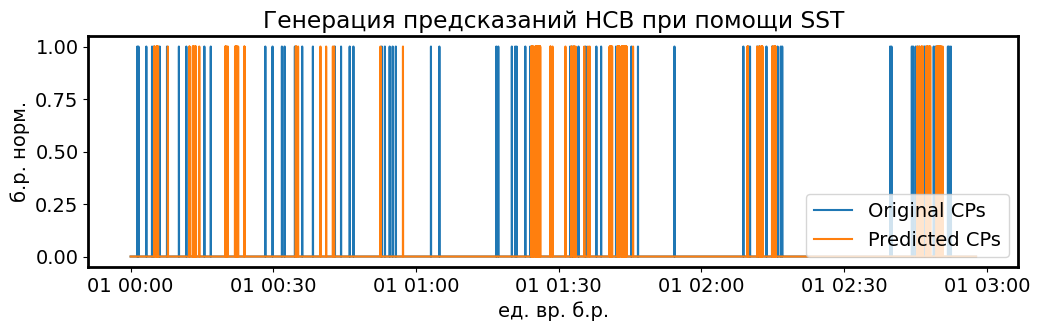

In [15]:
plt.figure(figsize=(12,3))
plt.plot(df['change_points'], label='Original CPs')
plt.plot(df['predicted_cp'],label='Predicted CPs')
plt.legend(loc="lower right")
plt.title('Генерация предсказаний НСВ при помощи SST')
plt.xlabel('ед. вр. б.р.')
plt.ylabel('б.р. норм.')
plt.show()

# Workflow Kalman Filter: 3 stage define Kalman Filter model

In [16]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [17]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def list_measured_function(window_size, ts):
    list_measured_pos = []
    for i in range(0, len(ts), window_size):
        temp = list(ts[i:i+window_size])
        mean_ts, var_ts = np.mean(temp), np.var(temp)
        list_measured_pos.append(gaussian(mean_ts, var_ts))
    return list_measured_pos

def make_one_step_prediction(list_measured_pos, g=gaussian(1, .5**2), window=10):
    list_prediction, predictions_mean, predictions_var = [], [], []
    for i in range(1,len(list_measured_pos)+1):
        prior, likelihood = predict(list_measured_pos[i-1], g), list_measured_pos[i-1]
        x = update(prior, likelihood)
      #  predictions_x.extend(np.random.normal(loc=x.mean, scale=x.var, size=window))
        predictions_mean.extend(np.full(window, x.mean))
        predictions_var.extend(np.full(window, x.var))
        list_prediction.append(x)
#     print()
#     print('final estimate:        {:10.3f}'.format(list_prediction[-1].mean))
#     print('actual final position: {:10.3f}'.format(list_measured_pos[-1].mean))
    return list_prediction, predictions_mean, predictions_var

# Workflow Kalman Filter: 4 stage apply Kalman Filter

In [18]:
list_measured_pos = list_measured_function(window_size= int(window_length), ts = time_series)
# list_measured_pos = list_measured_function(window_size= int(window_length/3.14), ts = time_series)

In [19]:
list_prediction, list_x_mean, list_x_var = make_one_step_prediction(list_measured_pos, g=gaussian(1, .18**2), window = int(window_length))
# list_prediction, list_x_mean, list_x_var = make_one_step_prediction(list_measured_pos, g=gaussian(1, .18**2), window = int(window_length/3.14))

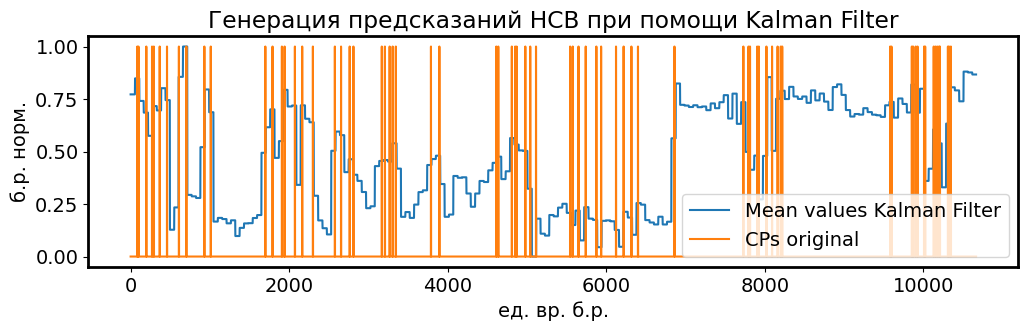

In [20]:
plt.figure(figsize=(12,3))
plt.plot(normalization_linear(list_x_mean[:len(df)]), label='Mean values Kalman Filter')
plt.plot(list(df['change_points']), label='CPs original')
plt.legend(loc="lower right")
plt.title('Генерация предсказаний НСВ при помощи Kalman Filter')
plt.xlabel('ед. вр. б.р.')
plt.ylabel('б.р. норм.')
plt.show()

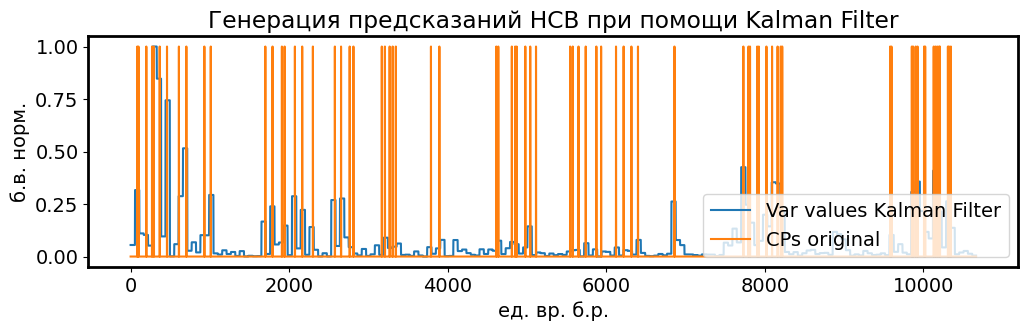

In [21]:
plt.figure(figsize=(12,3))
plt.plot(normalization_linear(list_x_var[:len(df)]), label='Var values Kalman Filter')
plt.plot(list(df['change_points']), label='CPs original')
plt.legend(loc="lower right")
plt.title('Генерация предсказаний НСВ при помощи Kalman Filter')
plt.xlabel('ед. вр. б.р.')
plt.ylabel('б.в. норм.')
plt.show()

# Workflow Kalman Filter: 5 stage find CPs

In [24]:
list_x_var_norm = list(normalization_linear(list_x_var[:len(df)])) + [0]
var_diff_list = [abs(list_x_var_norm[i] - list_x_var_norm[i+1]) for i in range(len(df)) if list_x_var_norm[i] != list_x_var_norm[i+1]]
mean_var_diff_ = np.mean(var_diff_list)
std_var_diff_ = np.std(var_diff_list)

print(mean_var_diff_)
print(std_var_diff_)

0.07940448912569521
0.1317391162291674


In [25]:
list_x_mean_norm = normalization_linear(list_x_mean)
mean_diff_list= [abs(list_x_mean_norm[i] - list_x_mean_norm[i+1]) for i in range(len(df)) if list_x_mean_norm[i] != list_x_mean_norm[i+1]]
mean_mean_diff_ = np.mean(mean_diff_list)
std_mean_diff_ = np.std(mean_diff_list)

print(mean_mean_diff_)
print(std_mean_diff_)

0.09752170285582022
0.1199705493041969


In [30]:
predicted_cp = [0]*len(df) #memoization
for i in range(len(df)):
    mean_current = list_x_mean_norm[i]
    var_current = list_x_var_norm[i]
    mean_next = list_x_mean_norm[i+1]
    var_next = list_x_var_norm[i+1]
    if abs(mean_current - mean_next) > mean_mean_diff_ + std_mean_diff_ or abs(var_current - var_next) > mean_var_diff_ + std_var_diff_:
        predicted_cp[i] = 1
    else:
        predicted_cp[i] = 0

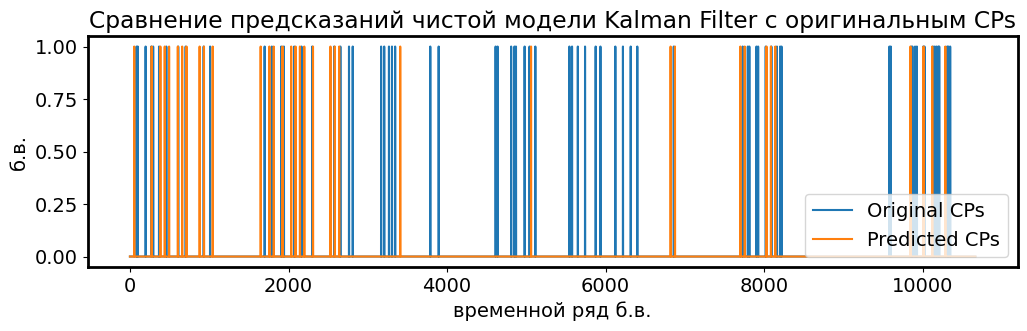

In [31]:
plt.figure(figsize=(12,3))
plt.plot(list(df['change_points']), label='Original CPs')
plt.plot(predicted_cp, label='Predicted CPs')
plt.legend(loc="lower right")
plt.title('Сравнение предсказаний чистой модели Kalman Filter с оригинальным CPs')
plt.xlabel('временной ряд б.в.')
plt.ylabel('б.в.')
plt.show()

# Workflow: 6 stage JOIN Kalman Filter and SST CPs

In [35]:
union_cps = [1 if predicted_cp[i] + df.predicted_cp[i] >= 1 else 0 for i in range(len(df))]

# Workflow: 7 stage apply queue filter

In [36]:
def queue(queue_window=10, time_series=None):
    queue = [0]*queue_window
    filtered_score = []
    for i in range(len(time_series)):
        value = time_series[i]
        if max(queue) != 0: #Вариант при котором CPs уже в очереди
            filtered_score.append(0)
            queue.pop(0)
            queue.append(0)
        else: # В очереди нет CPs
            filtered_score.append(value)
            queue.pop(0)
            queue.append(value)
    return filtered_score

In [39]:
sst_kalman_queue_cps = queue(queue_window=window_length, time_series=union_cps)
df['sst_kalman_queue_cps'] = sst_kalman_queue_cps

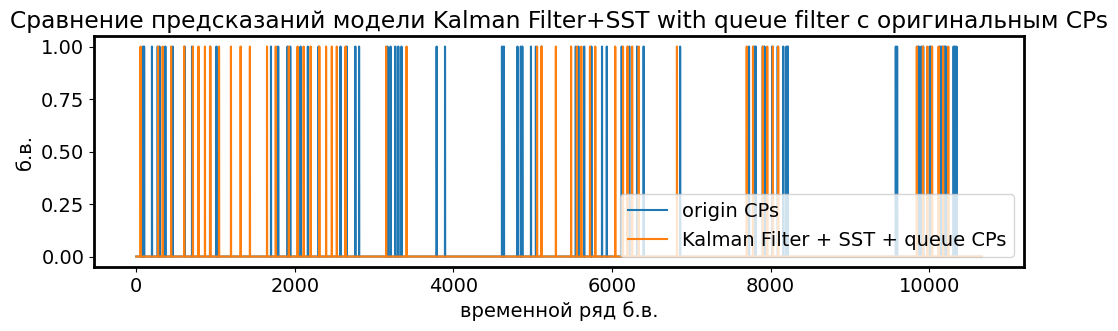

In [40]:
plt.figure(figsize=(12,3))
plt.plot(list(df['change_points']), label='origin CPs')
plt.plot(sst_kalman_queue_cps, label='Kalman Filter + SST + queue CPs')
plt.legend(loc="lower right")
plt.title('Сравнение предсказаний модели Kalman Filter+SST with queue filter с оригинальным CPs')
plt.xlabel('временной ряд б.в.')
plt.ylabel('б.в.')
plt.show()

# Workflow 8: create report

In [41]:
def create_report(experiment_results: dict):
    experiment_df = pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

In [44]:
%%capture --no-display
tsad_average_results = tsad_average(df.sst_kalman_queue_cps, df.change_points)

In [45]:
%%capture --no-display
tsad_nab_results = tsad_nab(df.sst_kalman_queue_cps, df.change_points)

In [46]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,18.32
LowFP,15.18
LowFN,21.22
Time_Delta,0 days 00:00:16.150000
Missed_CP,54
FPs,34
True_Anomalies_Count,74
precision,0.37037
recall,0.27027
F1,0.3125
